In [46]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

In [18]:
ma_list = [3,5,10,20,30]

df = yf.Ticker('AAPL').history(period='max')
df = df.iloc[:,:-2]
df.reset_index(inplace=True)

df['Premarket_Change'] = (df.Open - df.Close.shift(1))/df.Close.shift(1)

df['Price_Change'] = (df.Close - df.Open)/df.Open # Price Change: (Close - Open)/Open
df['Relevant_High'] = (df.High - df.Open)/df.Open # Relevant High: (High - Open)/Open
df['Relevant_Low'] = (df.Low - df.Open)/df.Open # Relevant Low: (Low - Open)/Open
df['Volume_Change'] = df.Volume.diff()/df.Volume # Volume Change: Volume.diff()/Volume

for ma in ma_list:
    df[f'Price_Change_{ma}MA'] = df['Price_Change'].rolling(ma).mean().shift(1)
    df[f'Volume_Change_{ma}MA'] = df['Volume_Change'].rolling(ma).mean().shift(1)
    
# Setting up target variable
up_list = []
for v in df['Price_Change']:
    if v > 0: up_list.append(1)
    else: up_list.append(0)
df['Call'] = up_list
del up_list

# ['Price_Change','Relevant_High','Relevant_Low','Volume_Change'] are 
# shifted one day since it is not possible to know these values at the beginning of the day
for col in df.columns[7:11]:
    df[col] = df[col].shift(1)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(['Open','High','Low','Close','Volume'],inplace=True, axis=1)
df

,Date,Premarket_Change,Price_Change,Relevant_High,Relevant_Low,Volume_Change,Price_Change_3MA,Volume_Change_3MA,Price_Change_5MA,Volume_Change_5MA,Price_Change_10MA,Volume_Change_10MA,Price_Change_20MA,Volume_Change_20MA,Price_Change_30MA,Volume_Change_30MA,Call
0,1981-01-28,-0.027342,-0.007751,0.000000,-0.007751,-0.039698,-0.005138,-0.554272,-0.003083,-0.400350,-0.002334,-0.238487,-0.002908,-0.235439,-0.002255,-0.249504,0
1,1981-01-29,-0.032256,-0.004016,0.000000,-0.004016,0.158313,-0.005209,0.221054,-0.003886,-0.190378,-0.002735,-0.161371,-0.002931,-0.209897,-0.002236,-0.188670,0
2,1981-01-30,-0.046030,-0.004166,0.000000,-0.004166,0.358673,-0.005311,0.159096,-0.004719,-0.229166,-0.003152,-0.123911,-0.002957,-0.145629,-0.002211,-0.154596,0
3,1981-02-02,-0.053094,-0.008771,0.000000,-0.008771,0.049467,-0.005651,0.188818,-0.005713,0.214260,-0.003627,-0.113948,-0.003396,-0.110632,-0.002504,-0.145510,0
4,1981-02-03,0.037556,-0.004673,0.000000,-0.004673,-0.943450,-0.005870,-0.178437,-0.005876,-0.083339,-0.004095,-0.276073,-0.003445,-0.177491,-0.002659,-0.171062,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10392,2022-05-27,0.011198,0.046510,0.050586,-0.001820,-0.020763,0.019471,-0.092425,0.017247,-0.086927,0.004700,-0.097891,-0.001495,-0.040468,-0.002748,-0.010369,1
10393,2022-05-31,-0.003809,0.029232,0.029507,-0.000894,0.004144,0.030280,-0.047530,0.025251,-0.087700,0.005880,-0.036999,0.001261,-0.040782,-0.000732,-0.012315,0
10394,2022-06-01,0.007122,-0.001543,0.010666,-0.014959,0.122832,0.024733,0.035404,0.017220,-0.030060,0.005733,0.006611,0.000785,-0.031173,-0.001017,-0.005175,0
10395,2022-06-02,-0.005918,-0.007939,0.012275,-0.014810,-0.396193,0.006583,-0.089739,0.016272,-0.083190,0.004684,-0.022403,-0.000032,-0.031825,-0.001762,-0.017742,1


In [19]:
# train, test = train_test_split(df, test_size=0.2)
train, test = df.iloc[:int(len(df)*0.8),:], df.iloc[int(len(df)*0.8):,:]

train_X, train_Y = train.iloc[:,1:-1], train['Call']
test_X, test_Y = test.iloc[:,1:-1], test['Call']

In [9]:
%%time
# Use Adaboost method with decision tree to train the model
max_d, max_e = 15,101
ada_pair_list = []
ada_score_record = np.array([])

for d in range(4,max_d,2):
    for e in range(5,max_e,5):
        ada_pair_list.append((d,e))
        model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), n_estimators=e, random_state=1)
        model.fit(train_X, train_Y)
        ada_score_record = np.append(ada_score_record, model.score(test_X,test_Y))

joblib.dump(model, 'AdaboostModel.sav')

CPU times: user 12min 12s, sys: 5.53 s, total: 12min 17s
Wall time: 12min 29s


The best combination is max_depth: 14, n_estimators: 100
The accuracy rate is 0.5259615384615385


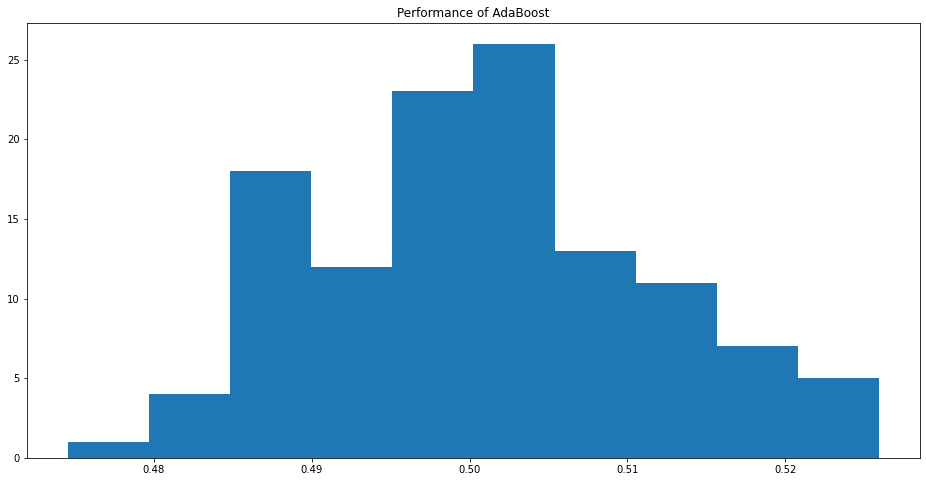

In [10]:
print(f'The best combination is max_depth: {ada_pair_list[ada_score_record.argmax()][0]}, n_estimators: {ada_pair_list[ada_score_record.argmax()][1]}')
print(f'The accuracy rate is {ada_score_record.max()}')
fig = plt.figure(figsize=(16,8))
plt.hist(ada_score_record)
plt.title('Performance of AdaBoost')
plt.show()

In [28]:
%%time
# Random Forest Classifier
forest_e_list = []
forest_score_record = np.array([])

for e in range(2, max_e, 2):
    forest_e_list.append(e)
    model = RandomForestClassifier(n_estimators=e, random_state=1)
    model.fit(train_X,train_Y)
    forest_score_record = np.append(forest_score_record, model.score(test_X, test_Y))

The best n_estimators: 76
The accuracy rate is 0.5411255411255411


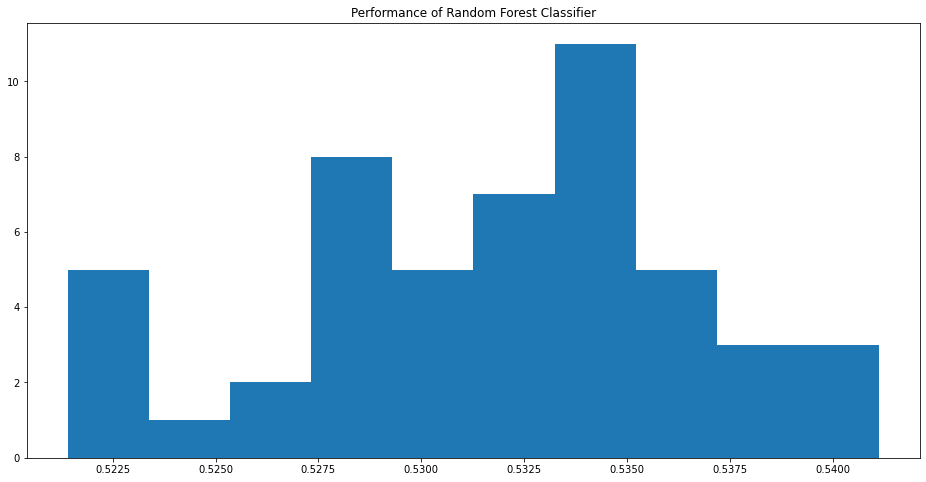

In [37]:
print(f'The best n_estimators: {forest_e_list[forest_score_record.argmax()]}')
print(f'The accuracy rate is {forest_score_record.max()}')
fig = plt.figure(figsize=(16,8))
plt.hist(forest_score_record)
plt.title('Performance of Random Forest Classifier')
plt.show()

In [43]:
# Support Vector Machine
svm_pair_list = []
svm_score_record = np.array([])

# Parameter Tuning
for c in [0.1,0.5,1,10,100,1000]:
    for g in [0.1,0.5,1,10,100,1000]:
        svm_pair_list.append((c,g))
        model = svm.SVC(C=c, gamma=g)
        model.fit(train_X, train_Y)
        svm_score_record = np.append(svm_score_record,model.score(test_X, test_Y))

The best combination is C: 1000, gamma: 0.5
The accuracy rate is 0.5497835497835498


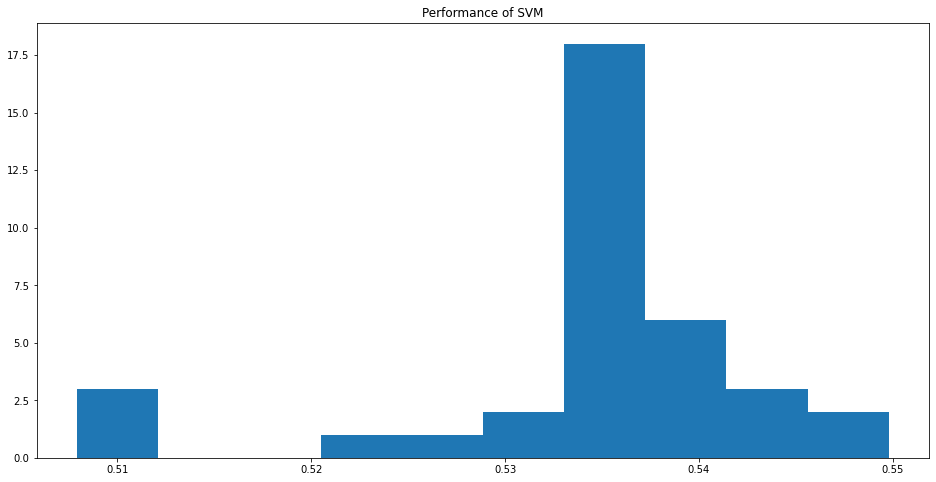

In [44]:
print(f'The best combination is C: {svm_pair_list[svm_score_record.argmax()][0]}, gamma: {svm_pair_list[svm_score_record.argmax()][1]}')
print(f'The accuracy rate is {svm_score_record.max()}')
fig = plt.figure(figsize=(16,8))
plt.hist(svm_score_record)
plt.title('Performance of SVM')
plt.show()